In [ ]:
import os

os.environ['KAGGLE_USERNAME'] = "daxinniu122" # username from the json file
os.environ['KAGGLE_KEY'] = "2ed6804df3e3e2e0d5053c862fa7020a" # key from the json file

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Library import
import pandas as pd
import os
import re
import tensorflow as tf
import pandas as pd
import os
import pickle
import re
import cv2
import albumentations as alb
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.applications import VGG19, ResNet152V2, InceptionResNetV2
from tensorflow.keras.layers import AveragePooling2D, Activation, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from functools import partial
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization, Activation
from tensorflow.keras.applications import EfficientNetB3, EfficientNetB4
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.applications import VGG16
from functools import partial
from sklearn.model_selection import train_test_split

# Constant Variables:
_auto_tune = tf.data.experimental.AUTOTUNE
_batch_size = 16

_image_width_original = 512
_image_height_original = 512
_image_size = [_image_width_original, _image_height_original]

_image_resize_width = 256
_image_resize_height = 256
_image_resize = [_image_resize_width, _image_resize_height]
print('Model input shape {} x {}.'.format(_image_resize_width, _image_resize_height))

_channels = 3
_n_class = 5
_n_repeat = 4
_img_norm = 255.0

_classes = [str(x) for x in range(_n_class)]
_major_label = 3
_classes_names = ['Cassava Bacterial Blight',
                  'Cassava Brown Streak Disease',
                  'Cassava Green Mottle',
                  'Cassava Mosaic Disease',
                  'Healthy']
_train_file = '/content/drive/MyDrive/cassava-leaf-disease-classification/'
_train_recs = list(filter(lambda x: '.tfrec' in x, os.listdir(_train_file)))
_epochs = 20
_valid_size = 0.1
_train_df = pd.read_csv('/content/drive/MyDrive/cassava-leaf-disease-classification/train.csv', encoding='utf_8_sig',
                        engine='python')
_file_label_map = dict(zip(_train_df.image_id.tolist(), _train_df.label.astype(int).tolist()))
_random_corp_size = [_image_resize_width, _image_resize_height, _channels]


# Decoding single image:
def decode_img(img,
               n_channels: int = _channels,
               img_size: list = None,
               img_norm: float = _img_norm):
    if img_size is None:
        img_size = _image_size
    img = tf.image.decode_jpeg(img, channels=n_channels)
    img = tf.reshape(img, [*img_size, n_channels])
    # img = tf.cast(img, tf.float32) / img_norm
    return img


# Parsing the files
def parse_img(x,
              n_class: int = _n_class):
    feature_description = {'image': tf.io.FixedLenFeature([], tf.string, default_value=''),
                           'target': tf.io.FixedLenFeature([], tf.int64, default_value=-1)}
    parsed_features = tf.io.parse_single_example(x, feature_description)
    img = decode_img(parsed_features['image'])
    label = tf.one_hot(parsed_features['target'], depth=n_class)
    return img, label


# Load data
def load_img(files: list,
             ordered=False):
    df = tf.data.TFRecordDataset(files)
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
    df = df.with_options(ignore_order)
    df = df.map(parse_img)
    return df


# Train-validation split
_train_fn, _valid_fn = \
    train_test_split(tf.io.gfile.glob(_train_file + 'ld_train*.tfrec'),
                     test_size=_valid_size,
                     random_state=5,
                     shuffle=True)

Model input shape 256 x 256.


In [ ]:

# Function for getting the training data set
def get_train_data(train_fn: list = _train_fn,
                   batch_size: int = _batch_size):
    df = load_img(train_fn)
    df = df.repeat().shuffle(2048).batch(batch_size).prefetch(_auto_tune)
    return df


# Function for getting the validation data set
def get_valid_data(valid_fn: list = _valid_fn,
                   batch_size: int = _batch_size):
    df = load_img(valid_fn)
    df = df.batch(batch_size).cache().prefetch(_auto_tune)
    return df


# Reporting the size of training, validation and testing data
def report_data_size(train_f=_train_fn,
                     valid_f=_valid_fn):
    def count_file(x):
        return sum([int(re.compile(r"-([0-9]*)\.").search(i).group(1)) for i in x])

    n_train, n_valid= count_file(train_f), count_file(valid_f)
    print('Train Images: {} | Validation Images: {}'.format(n_train, n_valid))
    return n_train, n_valid


# Check the size of the data
_n_train, _n_valid = report_data_size()

# Fetching training, validation and testing data
train_data = get_train_data()
valid_data = get_valid_data()

print("Train Data Size {} | Validation Data Size {}".format(train_data._flat_shapes, valid_data._flat_shapes))

Train Images: 18721 | Validation Images: 2676
Train Data Size [TensorShape([None, 512, 512, 3]), TensorShape([None, 5])] | Validation Data Size [TensorShape([None, 512, 512, 3]), TensorShape([None, 5])]


In [ ]:
input_module = tf.keras.layers.Input(shape=(*_image_size, _channels))
flip_module = tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical')
roration_module = tf.keras.layers.experimental.preprocessing.RandomRotation(factor=(-0.4, 0.4))
crop_module = tf.keras.layers.experimental.preprocessing.RandomCrop(height=_image_resize_height, width=_image_resize_width)
rand_height_module = tf.keras.layers.experimental.preprocessing.RandomHeight(factor=0.25)
rand_width_module = tf.keras.layers.experimental.preprocessing.RandomWidth(factor=0.25)
contrast_module = tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.3)
zoom_module = tf.keras.layers.experimental.preprocessing.RandomZoom(0.5, 0.3)
rescale_module = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1/255)

In [ ]:
def load_model():
    base = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(None, None, 3))

    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(5,
              activation='softmax')(x)
    m = Model(inputs=base.input, outputs=x)
    return m

In [ ]:
_opt = tf.keras.optimizers.Adam(lr=1e-05)
_loss = CategoricalCrossentropy(label_smoothing=0.05)
_epochs = 30
_finetune_epochs = 10

model_ver_4 = load_model()

In [ ]:
model = tf.keras.Sequential([input_module, 
                             flip_module,
                             roration_module,
                             crop_module,
                             rand_height_module,
                             rand_width_module,
                             contrast_module,
                             zoom_module,
                             model_ver_4])

In [ ]:
model.compile(
        optimizer=_opt,
        loss=_loss,
        metrics=['categorical_accuracy']
    )

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 512, 512, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 512, 512, 3)       0         
_________________________________________________________________
random_crop (RandomCrop)     (None, 336, 336, 3)       0         
_________________________________________________________________
random_height (RandomHeight) (None, None, 336, 3)      0         
_________________________________________________________________
random_width (RandomWidth)   (None, None, None, 3)     0         
_________________________________________________________________
random_contrast (RandomContr (None, None, None, 3)     0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, None, None, 3)     0

In [ ]:
_es = EarlyStopping(monitor='val_loss',
                    mode='min',
                    patience=10)
_r = ReduceLROnPlateau(monitor='val_loss',
                       factor=0.8,
                       patience=2,
                       verbose=1,
                       mode='auto',
                       epsilon=0.0001,
                       cooldown=5,
                       min_lr=0.00001)
_callback = [_es, _r]

history = model.fit(train_data, validation_data=valid_data, epochs=_epochs, callbacks=_callback, steps_per_epoch=_n_train//_batch_size)

model.save('/content/drive/MyDrive/cassava-leaf-disease-classification/ResNet152V2_ver_1.h5')

with open('/content/drive/MyDrive/cassava-leaf-disease-classification/ResNet152V2_ver_1.pkl', 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)

Epoch 1/30
1170/1170 [==============================] - 527s 431ms/step - loss: 1.1367 - categorical_accuracy: 0.6025 - val_loss: 0.8761 - val_categorical_accuracy: 0.7134
Epoch 2/30
1170/1170 [==============================] - 310s 265ms/step - loss: 0.8779 - categorical_accuracy: 0.7163 - val_loss: 0.8297 - val_categorical_accuracy: 0.7425
Epoch 3/30
1170/1170 [==============================] - 272s 233ms/step - loss: 0.8001 - categorical_accuracy: 0.7521 - val_loss: 0.7520 - val_categorical_accuracy: 0.7791
Epoch 4/30
1170/1170 [==============================] - 257s 220ms/step - loss: 0.7546 - categorical_accuracy: 0.7724 - val_loss: 0.7283 - val_categorical_accuracy: 0.7870
Epoch 5/30
1170/1170 [==============================] - 256s 219ms/step - loss: 0.7288 - categorical_accuracy: 0.7841 - val_loss: 0.7466 - val_categorical_accuracy: 0.7709
Epoch 6/30
1170/1170 [==============================] - 250s 214ms/step - loss: 0.7102 - categorical_accuracy: 0.7955 - val_loss: 0.6835 - v

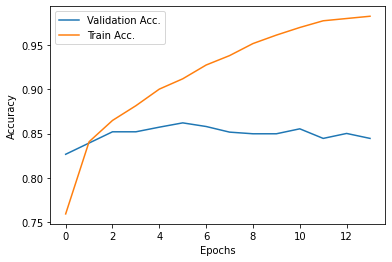

In [ ]:
plt.plot(history.history['val_categorical_accuracy'], label='Validation Acc.')
plt.plot(history.history['categorical_accuracy'], label='Train Acc.')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

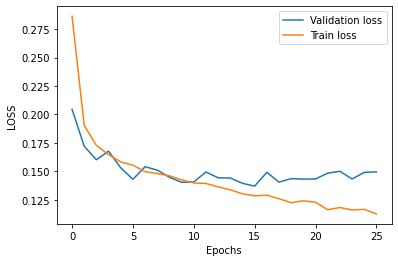

In [ ]:
plt.plot(history.history['val_loss'], label='Validation loss')
plt.plot(history.history['loss'], label='Train loss')
plt.xlabel('Epochs')
plt.ylabel('LOSS')
plt.legend()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/cassava-leaf-disease-classification/ResNet50_ver_1.h5')

In [ ]:
# Unfreezing the batch norm layers:
for layer in model_ver_4.layers:
    layer.trainable = True
    if 'bn' in layer.name:
        layer.trainable = False

Overfitting observed

In [ ]:
finetune_history = model.fit(train_data, validation_data=valid_data, epochs=10, callbacks=_callback, steps_per_epoch=_n_train//_batch_size)

Epoch 1/10
585/585 [==============================] - 236s 393ms/step - loss: 0.1082 - accuracy: 0.8962 - val_loss: 0.1921 - val_accuracy: 0.8408
Epoch 2/10
585/585 [==============================] - 232s 396ms/step - loss: 0.1068 - accuracy: 0.8990 - val_loss: 0.2083 - val_accuracy: 0.8449
Epoch 3/10
585/585 [==============================] - 232s 396ms/step - loss: 0.1081 - accuracy: 0.8975 - val_loss: 0.2171 - val_accuracy: 0.8442
Epoch 4/10
585/585 [==============================] - 228s 390ms/step - loss: 0.1050 - accuracy: 0.9001 - val_loss: 0.2314 - val_accuracy: 0.8445
Epoch 5/10
585/585 [==============================] - 230s 393ms/step - loss: 0.1031 - accuracy: 0.9009 - val_loss: 0.2044 - val_accuracy: 0.8401
Epoch 6/10
585/585 [==============================] - 228s 390ms/step - loss: 0.1030 - accuracy: 0.9021 - val_loss: 0.2443 - val_accuracy: 0.8270
Epoch 7/10
585/585 [==============================] - 229s 391ms/step - loss: 0.1003 - accuracy: 0.9033 - val_loss: 0.2458 -